# SDR Python Simulator Notebook

### Done
- IQ Modulaton and Sampling
- Pulse Shaping
- Noise and dB
- Filters
- Digital Modulation

### ToDo
- Synchronization
- Multipath Fading
- Link Budget
- Channel Coding
- IQ Files and SigMF

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.constants import k
from sdr_utils import *


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
# Carrier frequency
fc = 10
BW = 30e6 # 30MHz bandwidth
T = 293.15 # temperature in kelvin
sps = 8
Fs = 1 # sample rate
Ts = 1/Fs

message = np.array("Hello World".encode("ascii"))
bin_v = np.vectorize(bin)
bytea_v = np.vectorize(bytearray)
int_v = np.vectorize(int)

bin_message = bin_v(bytea_v(message))
m0 = int_v(list(bin_message[0][2:]))


t = np.arange(0, Ts*len(m0), Ts/100)

bpsk_m0 = BPSK_IQV(m0)
m_values = []
for n, v in enumerate(bpsk_m0):
    m_values.append(IQ_to_time(v, fc, Ts, n))



m = np.concatenate(m_values)
m_bin = np.repeat(m0, 100, axis=0)

m_bpsk = BPSK(m0)

print(f"binary data: {m0}")
print(f"BPSK data: {m_bpsk}")

m_send = np.array([]) # raw impulse train with filler zeroes
for bit in m0:
    pulse = np.zeros(sps)
    pulse[0] = bit*2-1 # set the first value to either a 1 or -1
    m_send = np.concatenate((m_send, pulse)) # add the 8 samples to the signal


binary data: [1 0 0 1 0 0 0]
BPSK data: [ 1 -1 -1  1 -1 -1 -1]


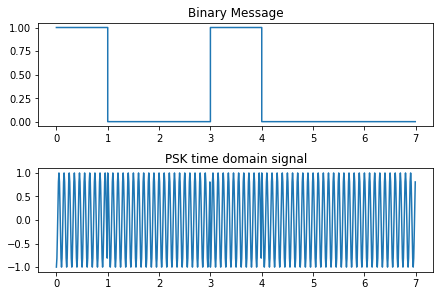

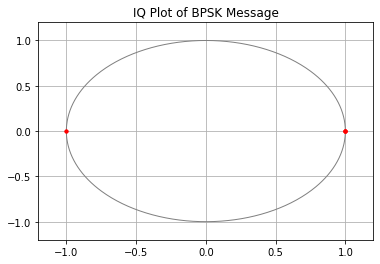

In [3]:
figure, axis = plt.subplots(2, constrained_layout = True)
axis[0].step(t, m_bin, where="post")
axis[0].title.set_text("Binary Message")
axis[1].plot(t, m[:len(t)])
axis[1].title.set_text("PSK time domain signal")
plt.show()

tc = np.arange(0,2*np.pi,1e-2)
plt.plot(np.cos(tc), np.sin(tc), linewidth=1, color="grey")
plt.plot(np.real(bpsk_m0), np.imag(bpsk_m0), '.', color="red")
plt.title("IQ Plot of BPSK Message")
plt.grid(True)
plt.xlim([-1.2, 1.2])
plt.ylim([-1.2, 1.2])
plt.show()

In [4]:
num_taps = 101
def f_shape_plot(β):
    global m_send, num_taps, sps
    m_shaped = raised_cos_filter(m_send, β, sps=sps, num_taps=num_taps)
    plt.figure(0)
    plt.plot(m_shaped, ".-")
    plt.title("Shaped Message, time domain")
    for i in range(len(m0)):
        plt.plot([i*sps+num_taps//2+1,i*sps+num_taps//2+1], [0, m_shaped[i*sps+num_taps//2+1]], color="red")
    plt.grid(True)


interact(f_shape_plot, β=(0,1,0.05));

interactive(children=(FloatSlider(value=0.0, description='β', max=1.0, step=0.05), Output()), _dom_classes=('w…

In [5]:
## Let's take a more detailed look at the raised-cos filter
def plot_raised_cos_fft(β):
    beta = β
    num_taps = 101
    Ts = 8 # Assume sample rate is 1 Hz, so sample period is 1, so *symbol* period is 8
    th = np.arange(-1*(num_taps//2), (num_taps//2)+1) # remember it's not inclusive of final number
    h = 1/Ts*np.sinc(th/Ts) * np.cos(np.pi*beta*th/Ts) / (1 - (2*beta*th/Ts)**2) # raised-cosine filter
    h*=Ts
    plt.plot(h, ".-")
    plt.title("h(t), time domain of raised cos filter")
    plt.show()
    H = np.fft.fftshift(np.fft.fft(h))
    #H = H[num_taps//2:] # only look at positive frequencies.  remember // is just an integer divide
    plt.plot(np.abs(np.real(H)), '.-')
    plt.title("H(f), frequency domain of raised cos filter")
    plt.show()

interact(plot_raised_cos_fft, β=(0,1,0.05));

interactive(children=(FloatSlider(value=0.0, description='β', max=1.0, step=0.05), Output()), _dom_classes=('w…

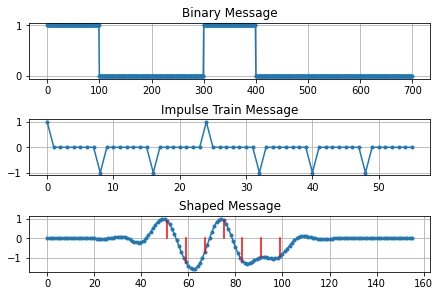

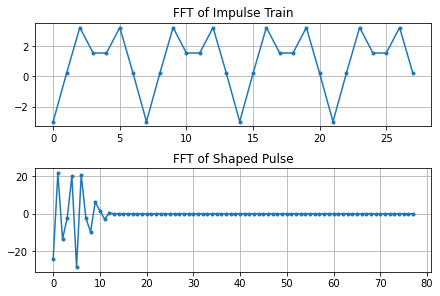

In [6]:
## Compare frequency domain characteristics of the shaped vs unshaped signals
# static shaped message for BPSK
β = 0.35
m_shaped = raised_cos_filter(m_send, β, sps=sps, num_taps=num_taps)

# show shaped vs unshaped in the time domain
figure, axis = plt.subplots(3, constrained_layout = True)
axis[0].plot(m_bin, '.-')
axis[0].title.set_text("Binary Message")
axis[1].plot(m_send, '.-')
axis[1].title.set_text("Impulse Train Message")
axis[2].plot(m_shaped, '.-')
axis[2].title.set_text("Shaped Message")
axis[0].grid(True)
axis[1].grid(True)
axis[2].grid(True)
for i in range(len(m0)):
    axis[2].plot([i*sps+num_taps//2+1,i*sps+num_taps//2+1], [0, m_shaped[i*sps+num_taps//2+1]], color="red")

plt.show()

# show shaped vs unshaped in the frequency domain
m_send_fft = np.fft.fftshift(np.fft.fft(m_send))
m_send_fft = m_send_fft[len(m_send)//2:] # only look at positive frequencies.  remember // is just an integer divide
m_shaped_fft = np.fft.fftshift(np.fft.fft(m_shaped))
m_shaped_fft = m_shaped_fft[len(m_shaped)//2:] # only look at positive frequencies.  remember // is just an integer divide

figure, axis = plt.subplots(2, constrained_layout = True)
axis[0].plot(np.real(m_send_fft), '.-')
axis[0].title.set_text("FFT of Impulse Train")
axis[1].plot(np.real(m_shaped_fft), '.-')
axis[1].title.set_text("FFT of Shaped Pulse")
axis[0].grid(True)
axis[1].grid(True)
plt.show()


In [7]:


## Modeling Losses and Noise
# Modeling Losses
P_noise = k*T*BW
#Random noise
N = len(m_shaped)
n = ((np.random.randn(N) + 1j*np.random.randn(N))/np.sqrt(2))
power = np.var(n)
#print(f"power: {power}")
#print(f"power of noise: {P_noise}")

def plot_quadrature(SNR):
    # assume signal power = 1
    P_signal = 1
    P_noise = P_signal/SNR
    N = len(m_shaped)
    # Generate AWGN
    n = ((np.random.randn(N) + 1j*np.random.randn(N))/np.sqrt(2)) * P_noise
    
    I = m_shaped
    Q = np.zeros(len(m_shaped))
    IQ_send = I + 1j*Q
    IQ_recieve = IQ_send + n
    plt.figure(1)
    plt.plot(np.real(IQ_recieve), ".-")
    data = []
    samples = []
    for i in range(len(m0)):
        k = np.real(IQ_recieve[i*sps+num_taps//2+1]) > 0
        samples.append(IQ_recieve[i*sps+num_taps//2+1])
        data.append(1 if k else 0)
        plt.plot([i*sps+num_taps//2+1,i*sps+num_taps//2+1], [0, m_shaped[i*sps+num_taps//2+1]], color="blue")
    print(data)
    plt.grid(True)
    plt.title("Quadrature with noise")
    plt.show()
    
    samples = np.array(samples)
    tc = np.arange(0,2*np.pi,1e-2)
    plt.plot(np.cos(tc), np.sin(tc), linewidth=1, color="grey")
    plt.plot(np.real(samples), np.imag(samples), '.', color="red")
    plt.title("IQ Plot of Noisy Quadrature")
    plt.grid(True)
    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    plt.show()

interact(plot_quadrature, SNR=(1,100,1));

interactive(children=(IntSlider(value=50, description='SNR', min=1), Output()), _dom_classes=('widget-interact…

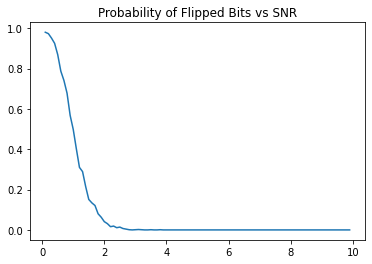

In [8]:
# Let's see how SNR influences bit flips
def bit_flips(SNR):
    good_data = [1, 0, 0, 1, 0, 0, 0]
    # assume signal power = 1
    P_signal = 1
    P_noise = P_signal/SNR
    N = len(m_shaped)
    # Generate AWGN
    n = ((np.random.randn(N) + 1j*np.random.randn(N))/np.sqrt(2)) * P_noise
    
    I = np.zeros(len(m_shaped))
    Q = m_shaped
    IQ_send = I + 1j*Q
    IQ_recieve = IQ_send + n
    data = []
    for i in range(len(m0)):
        k = np.imag(IQ_recieve[i*sps+num_taps//2+1]) > 0
        data.append(1 if k else 0)
    return data != good_data

epochs = 1000
SNR = np.arange(0.1,10,0.1)
flips = []
for snr in SNR:
    num_flips = 0
    for i in range(epochs):
        if bit_flips(snr):
            num_flips += 1
            
    flips.append(num_flips)

flips = np.array(flips, dtype="float64")
flips /= epochs
plt.plot(SNR, flips)
plt.title("Probability of Flipped Bits vs SNR")
plt.show()

In [9]:
## Synchonization Begins 

# Adding a delay
# Create and apply fractional delay filter
# using m_shaped without noise
def delay_plot(Δsample, N_taps):
    delay = Δsample # fractional delay, in samples
    N = N_taps #21 # number of taps
    n = np.arange(-N//2, N//2) # ...-3,-2,-1,0,1,2,3...
    h = np.sinc(n - delay) # calc filter taps
    h *= np.hamming(N) # window the filter to make sure it decays to 0 on both sides
    h /= np.sum(h) # normalize to get unity gain, we don't want to change the amplitude/power
    m_shaped_delay = np.convolve(m_shaped, h) # apply filter

    plt.plot(m_shaped, zorder = 1)
    plt.plot(m_shaped_delay, zorder = 2)
    plt.legend(["Original", "Delayed"])
    plt.show()
    
interact(delay_plot, Δsample=(0,3,0.1), N_taps=(1,100,1));

interactive(children=(FloatSlider(value=1.0, description='Δsample', max=3.0), IntSlider(value=50, description=…

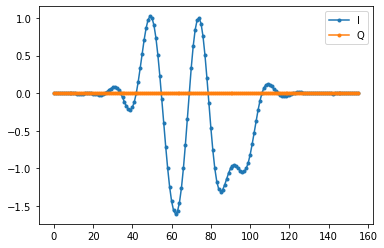

interactive(children=(FloatSlider(value=10000.0, description='Δf', max=20000.0, step=100.0), Output()), _dom_c…

In [10]:
## Frequency Offset
I = m_shaped
Q = np.zeros(len(m_shaped))
IQ_send = I + 1j*Q

plt.plot(np.real(IQ_send), '.-', zorder = 1)
plt.plot(np.imag(IQ_send), '.-', zorder = 2)
plt.legend(["I", "Q"])
plt.show()

def plot_fo(Δf):
    fs = 1e6 # assume our sample rate is 1 MHz
    fo = Δf #13000 # simulate freq offset
    Ts = 1/fs # calc sample period
    t = np.arange(0, Ts*len(IQ_send), Ts) # create time vector
    IQ_recv = IQ_send * np.exp(1j*2*np.pi*fo*t) # perform freq shift
    plt.plot(np.real(IQ_recv), '.-', zorder = 1)
    plt.plot(np.imag(IQ_recv), '.-', zorder = 2)
    plt.legend(["I", "Q"])
    plt.show()
    
    tc = np.arange(0,2*np.pi,1e-2)
    plt.plot(np.cos(tc), np.sin(tc), linewidth=1, color="grey")
    plt.plot(np.real(IQ_recv), np.imag(IQ_recv), '.', color="red")
    plt.title("IQ Plot of Noisy Quadrature")
    plt.grid(True)
    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    plt.show()
interact(plot_fo, Δf = (0, 20e3, 100));

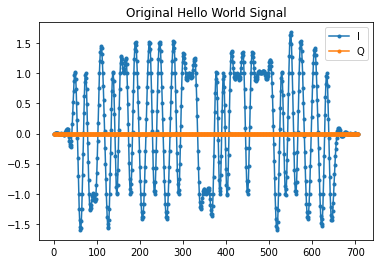

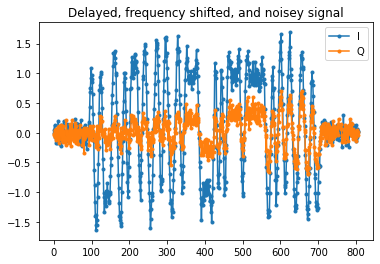

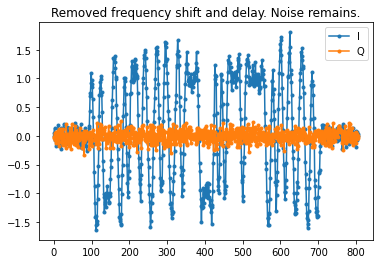

In [11]:
## Using quick utilities:
bin_msg = binaryify("Hello World")
train = pulse_train(bin_msg)
shaped = raised_cos_filter(train, β = 0.35)

I = shaped
Q = np.zeros(len(shaped))
IQ_send = I + 1j*Q

plt.plot(np.real(IQ_send), '.-', zorder = 1)
plt.plot(np.imag(IQ_send), '.-', zorder = 2)
plt.legend(["I", "Q"])
plt.title("Original Hello World Signal")
plt.show()

IQ = add_delay(IQ_send, N=100)
IQ = add_frequency_offset(IQ, Δf = 100)
IQ = add_AWGN(IQ, SNR = 7)
plt.plot(np.real(IQ), '.-', zorder = 1)
plt.plot(np.imag(IQ), '.-', zorder = 2)
plt.legend(["I", "Q"])
plt.title("Delayed, frequency shifted, and noisey signal")
plt.show()

IQ2 = add_delay(IQ, Δsample=-1, N=100)
IQ2 = add_frequency_offset(IQ, Δf = -100)
plt.plot(np.real(IQ2), '.-', zorder = 1)
plt.plot(np.imag(IQ2), '.-', zorder = 2)
plt.legend(["I", "Q"])
plt.title("Removed frequency shift and delay. Noise remains.")
plt.show()

In [12]:
## Mueller and Muller clock recovery technique
samples = IQ
mu = 0 # initial estimate of phase of sample
out = np.zeros(len(samples) + 10, dtype=np.complex)
out_rail = np.zeros(len(samples) + 10, dtype=np.complex) # stores values, each iteration we need the previous 2 values plus current value
i_in = 0 # input samples index
i_out = 2 # output index (let first two outputs be 0)
while i_out < len(samples) and i_in+16 < len(samples):
    out[i_out] = samples[i_in + int(mu)] # grab what we think is the "best" sample
    out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
    x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
    y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
    mm_val = np.real(y - x)
    mu += sps + 0.3*mm_val
    i_in += int(np.floor(mu)) # round down to nearest int since we are using it as an index
    mu = mu - np.floor(mu) # remove the integer part of mu
    i_out += 1 # increment output index
out = out[2:i_out] # remove the first two, and anything after i_out (that was never filled out)
samples = out # only include this line if you want to connect this code snippet with the Costas Loop later on

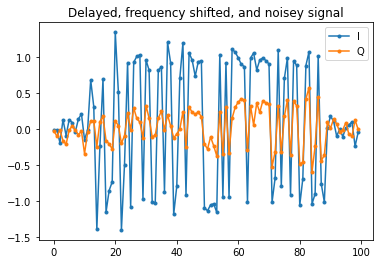

In [13]:

plt.plot(np.real(samples), '.-', zorder = 1)
plt.plot(np.imag(samples), '.-', zorder = 2)
plt.legend(["I", "Q"])
plt.title("Delayed, frequency shifted, and noisey signal")
plt.show()